In [438]:
%matplotlib inline

import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import models
from keras.preprocessing.image import ImageDataGenerator
import keras.losses
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn
from matplotlib import cm

In [496]:
m = scipy.io.loadmat('/Users/sean/Desktop/imR_dupes.mat')
imR = np.moveaxis(m['imR_dupes'], 2, 0)
imR = np.reshape(imR, imR.shape + (1,))

# m_testing = scipy.io.loadmat('/Users/sean/Desktop/imR.mat')
# imR_testing = np.moveaxis(m_testing['imR'], 2, 0)
# imR_testing = np.reshape(imR_testing, imR_testing.shape + (1,))

# y = np.loadtxt('/Users/sean/code/wormAnalysis/data/movement_v2.dat', skiprows=1, delimiter=',')

In [338]:
x_train, x_test = train_test_split(imR-.5)

In [372]:
input_img = Input(shape=imR.shape[1:])  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), padding='same')(input_img)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3))(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 28, 68, 1)         0         
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 28, 68, 16)        160       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 68, 16)        0         
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 14, 34, 16)        0         
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 14, 34, 8)         1160      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 34, 8)         0         
_________________________________________________________________
max_pooling2d_130 (MaxPoolin (None, 7, 17, 8)          0         
__________

In [379]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder/run3')])

Train on 2394 samples, validate on 798 samples
Epoch 1/100
2394/2394 [==============================] - 7s 3ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 2/100
2394/2394 [==============================] - 6s 2ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 3/100
2394/2394 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 4/100
2394/2394 [==============================] - 6s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 6/100
2394/2394 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 7/100
2394/2394 [==============================] - 5s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 8/100
2394/2394 [==============================] - 6s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 9/100
2394/2394 [==============================] - 6s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/100
2394/2394 [==

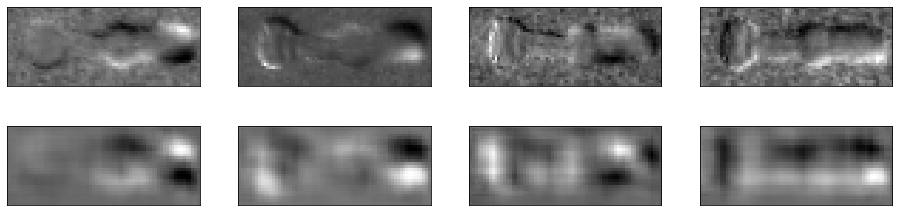

In [398]:
decoded_imgs = autoencoder.predict(x_test)

n = 5
plt.figure(figsize=(20, 4))

skip_val = 40
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i+skip_val].reshape(imR.shape[1:3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i+skip_val].reshape(imR.shape[1:3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [497]:
layer_name = 'encoded'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(imR-.5)

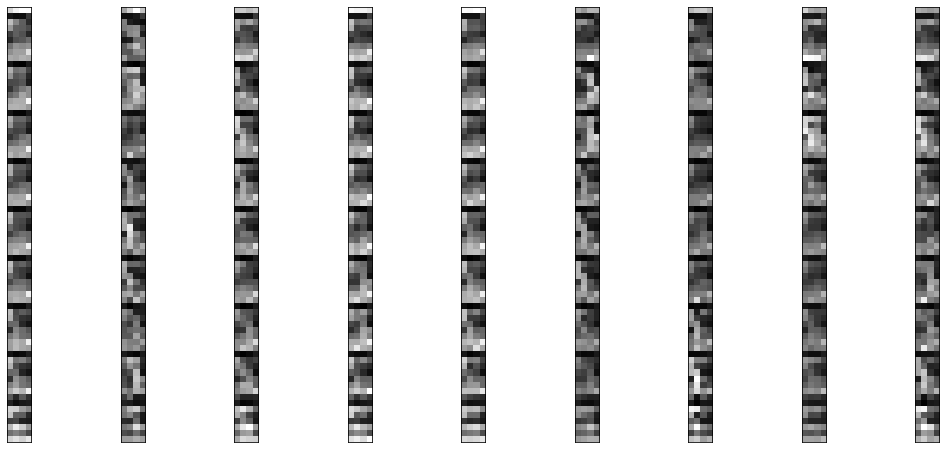

In [376]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(intermediate_output[i].reshape(4, 9 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [498]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(intermediate_output.reshape(imR.shape[0], 4*9*8))
np.savetxt('/Users/sean/Desktop/x_pca3.csv', x_pca, delimiter=',')

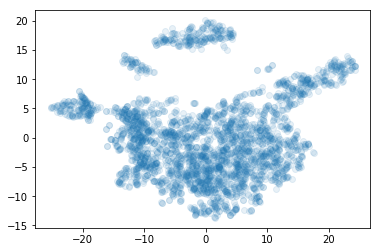

In [499]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(intermediate_output.reshape(imR.shape[0], 4*9*8))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.1)

In [500]:
np.savetxt('/Users/sean/Desktop/x_tsne.csv', X_tsne, delimiter=',')

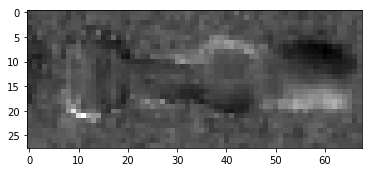

In [284]:
plt.imshow(imR[43,:,:,0])

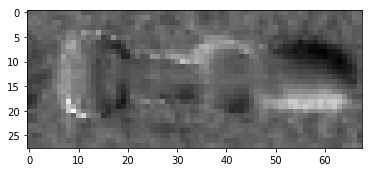

In [285]:
plt.imshow(imR[100,:,:,0])

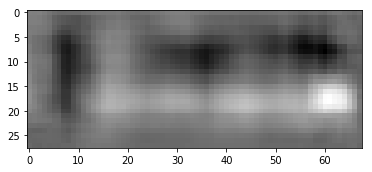

In [403]:
plt.imshow(decoded_imgs[44,:,:,0])

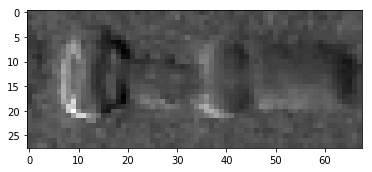

In [411]:
plt.imshow(x_test[64,:,:,0])

In [431]:
testing_output = intermediate_layer_model.predict(imR_testing)

In [432]:
testing_output.shape

(57, 4, 9, 8)

In [478]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(testing_output.reshape(testing_output.shape[0], 4*9*8))

In [482]:
y.shape

(301,)

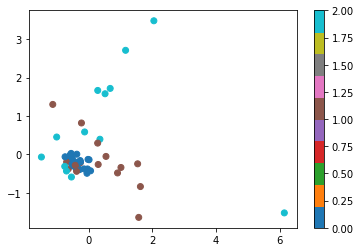

In [485]:
_=plt.scatter(x_pca[:,0], x_pca[:,1], c=y[:,0], cmap=plt.get_cmap('tab10'))
_=plt.colorbar()

In [417]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [415]:
X_tsne.shape

(2394, 3)

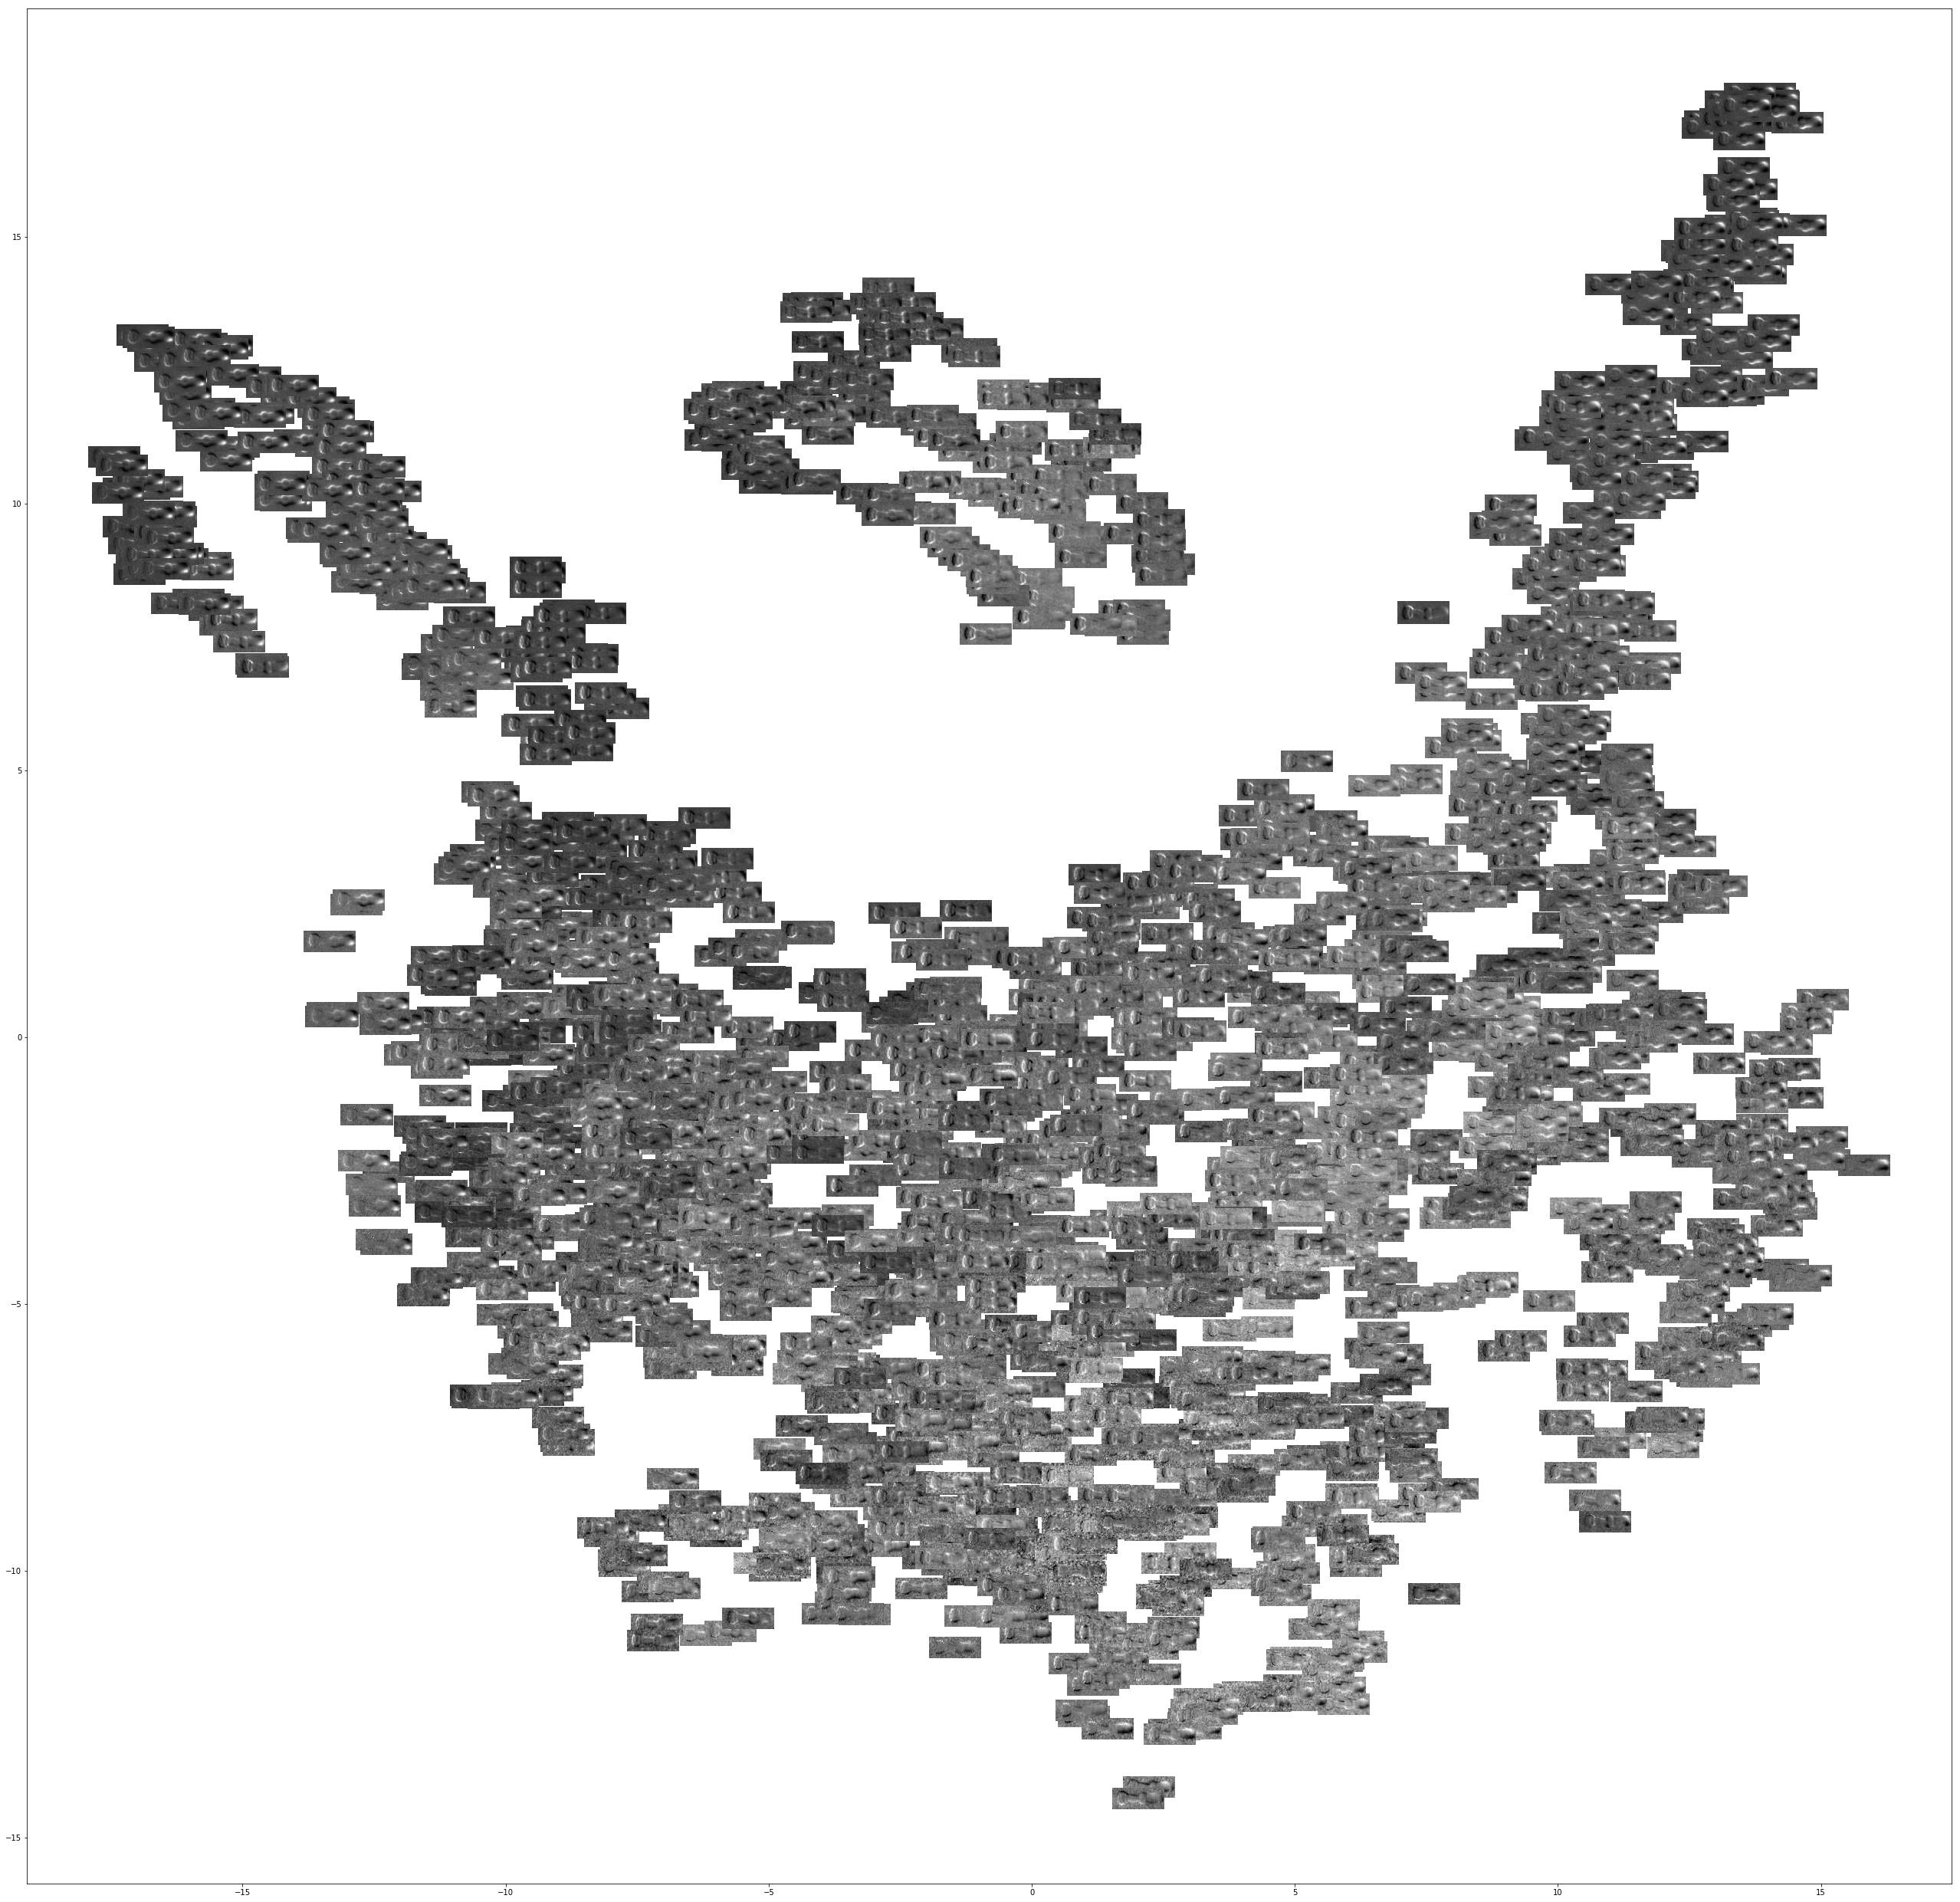

In [423]:
visualize_scatter_with_images(X_tsne[:,0:2], x_train[:,:,:,0])

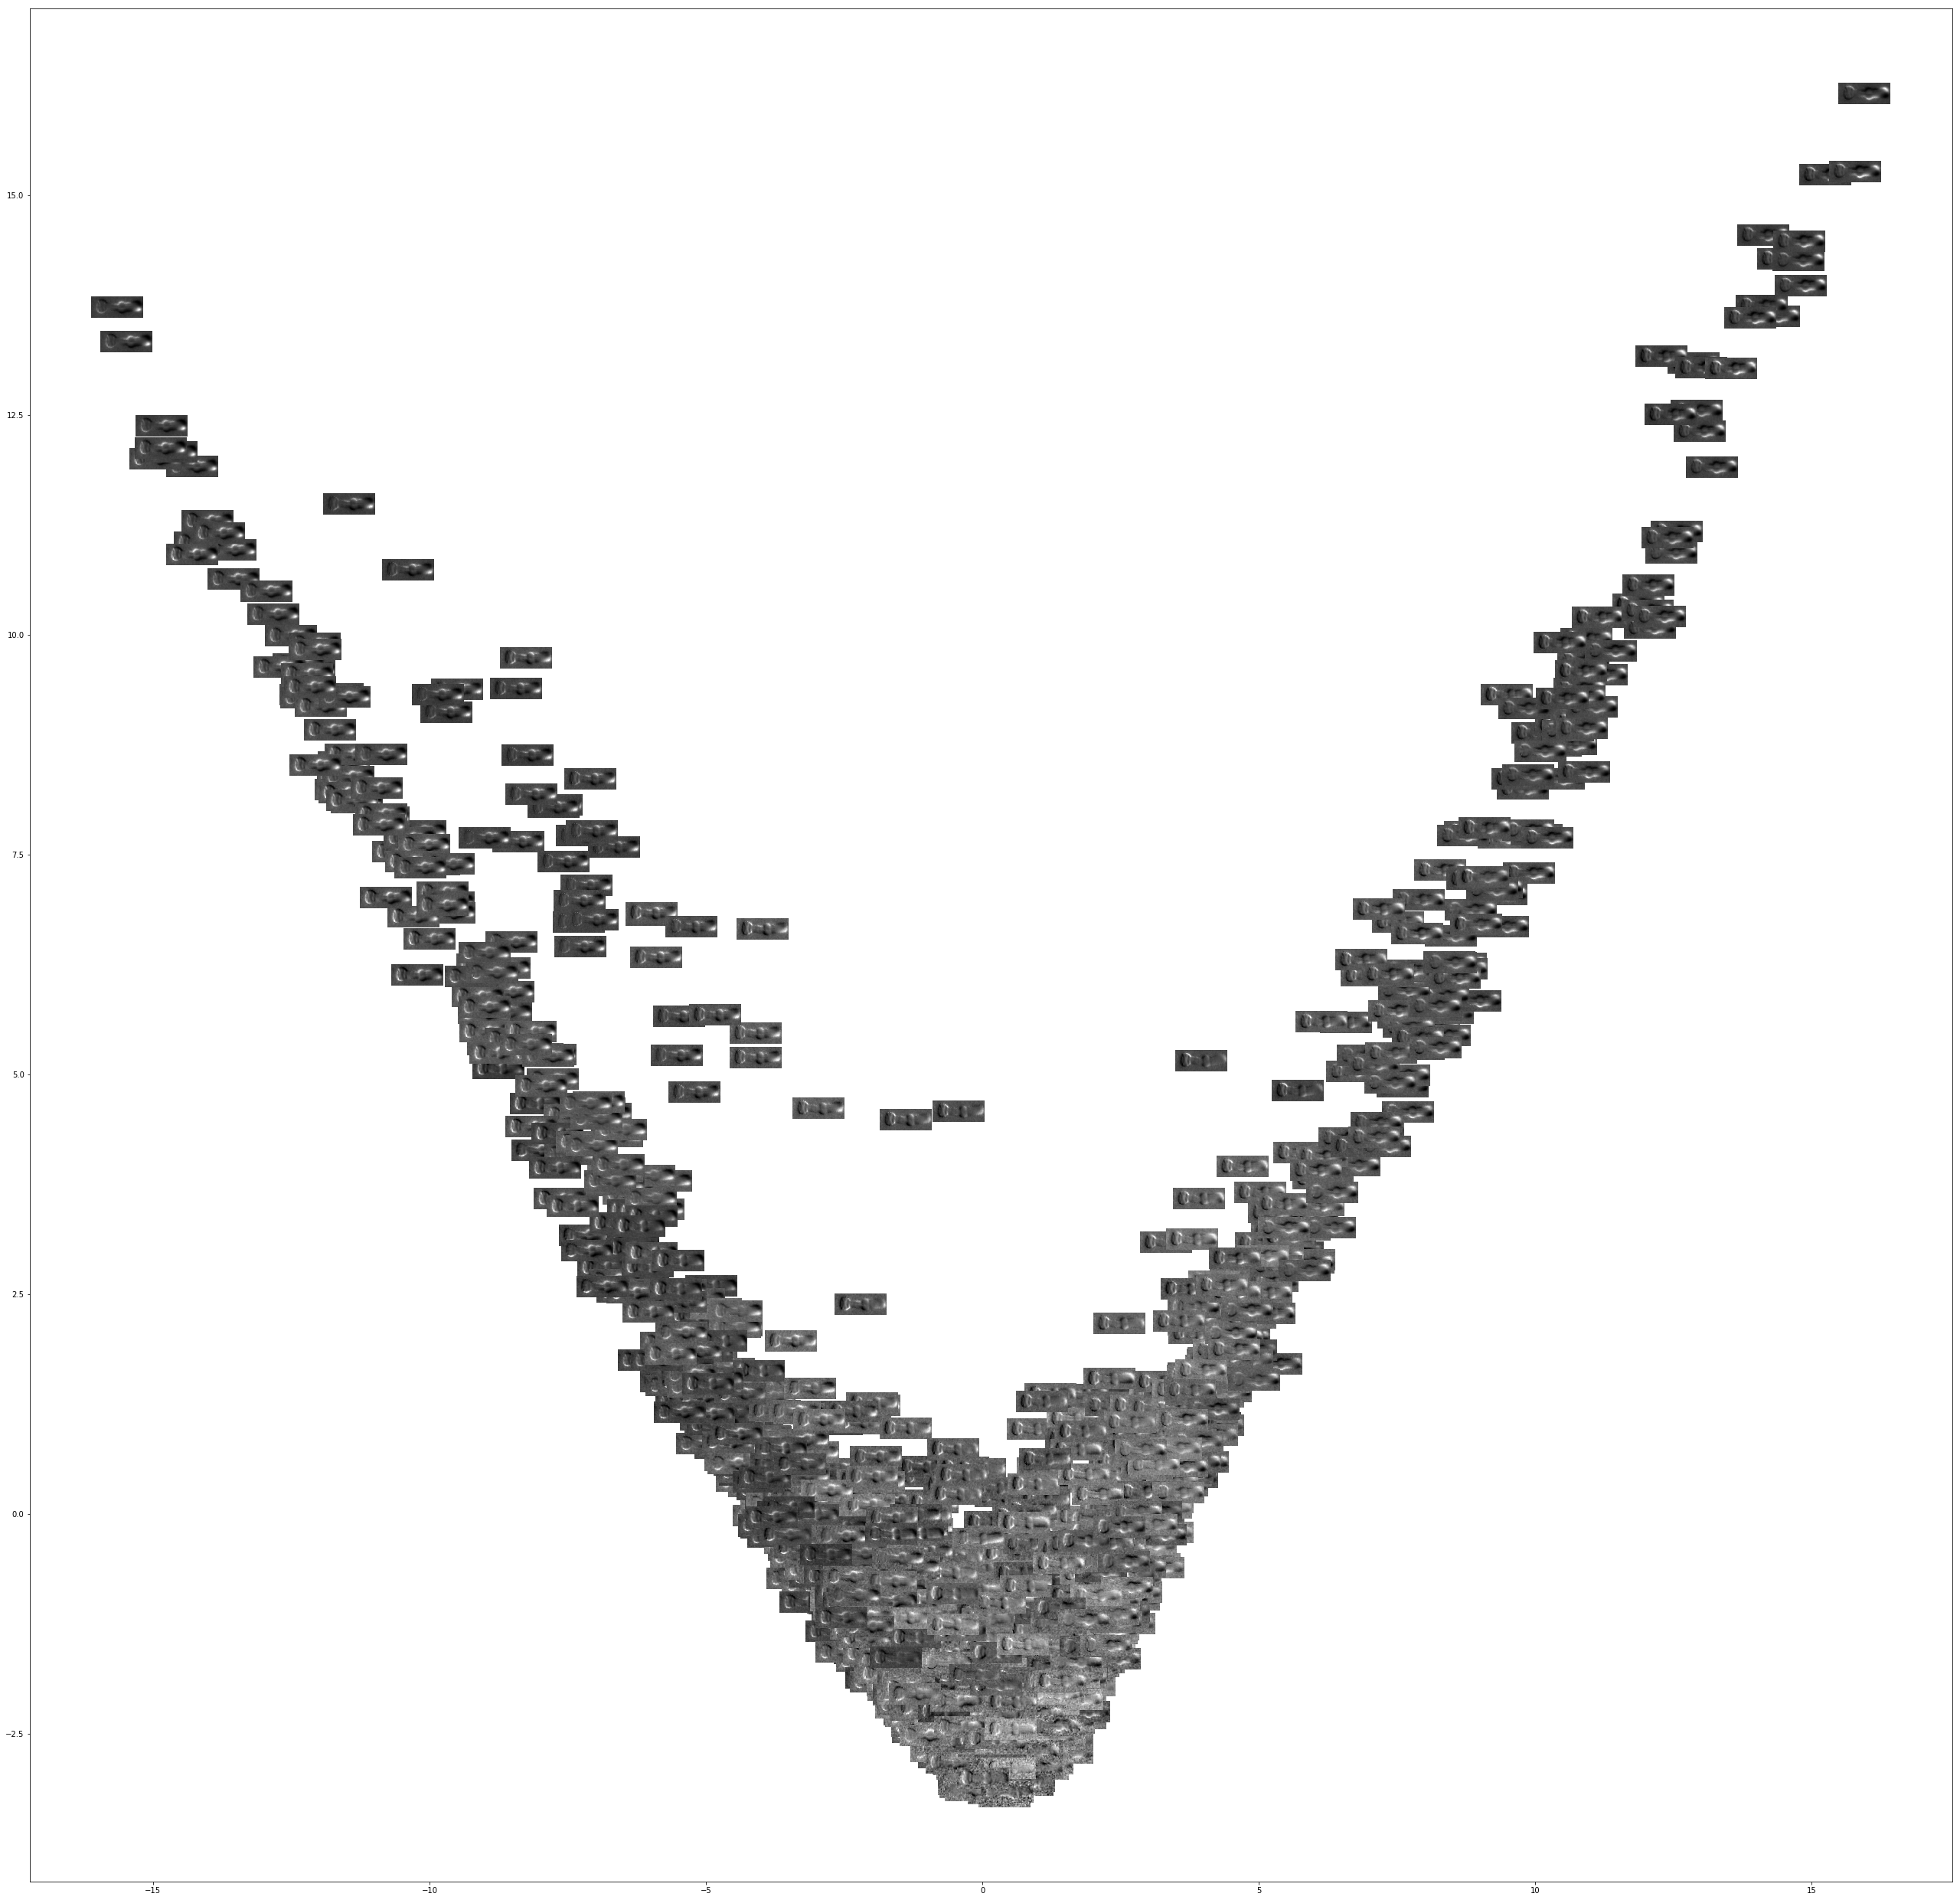

In [424]:
visualize_scatter_with_images(x_pca[:,0:2], x_train[:,:,:,0])

In [469]:
np.savetxt('/Users/sean/Desktop/x_ravel.csv', x_train.ravel(), delimiter=',')

In [472]:
np.savetxt('/Users/sean/Desktop/x_pca3.csv', x_pca, delimiter=',')
np.savetxt('/Users/sean/Desktop/x_tsne3.csv', X_tsne, delimiter=',')